In [1]:
%matplotlib inline
import sys
sys.path.append('../../code')
import os
import numpy as np
import torch
import pickle
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from helper import *
from data import *

## Load nuScenes SDK and data

In [3]:
nuScenes_data_path = # Data Path to nuScenes data set 
nuScenes_devkit_path = '../../data/nuScenes/nuscenes-devkit/python-sdk/'
sys.path.append(nuScenes_devkit_path)
from nuscenes.map_expansion.map_api import NuScenesMap
nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name='singapore-queenstown')

In [4]:
line_colors = ['#375397','#80CBE5','#ABCB51','#F05F78', '#C8B0B0']

# Map Encoding Demo

In [5]:
with open('../../data/processed/nuScenes_samples.pkl', 'rb') as f:
    eval_env = pickle.load(f, encoding='latin1')
eval_scenes = eval_env.scenes

In [6]:
ph = 6
log_dir = '../../data/nuScenes/models'
model_dir = os.path.join(log_dir, 'me_demo') 
eval_stg, hyp = load_model(model_dir, eval_env, ts=1)


Loading from ../../data/nuScenes/models/me_demo/model_registrar-1.pt
Loaded!



In [7]:
# Load Scene
for s_scene in eval_scenes:
    if s_scene.name == "1002":
        scene = s_scene

In [8]:
# Define ROI in nuScenes Map
x_min = 262.0
x_max = 560.0
y_min = 1864.0
y_max = 2071.0

In [9]:
layers = ['drivable_area',
          'road_segment',
          'lane',
          'ped_crossing',
          'walkway',
          'stop_line',
          'road_divider',
          'lane_divider']

## Prediction including Map Encoding

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


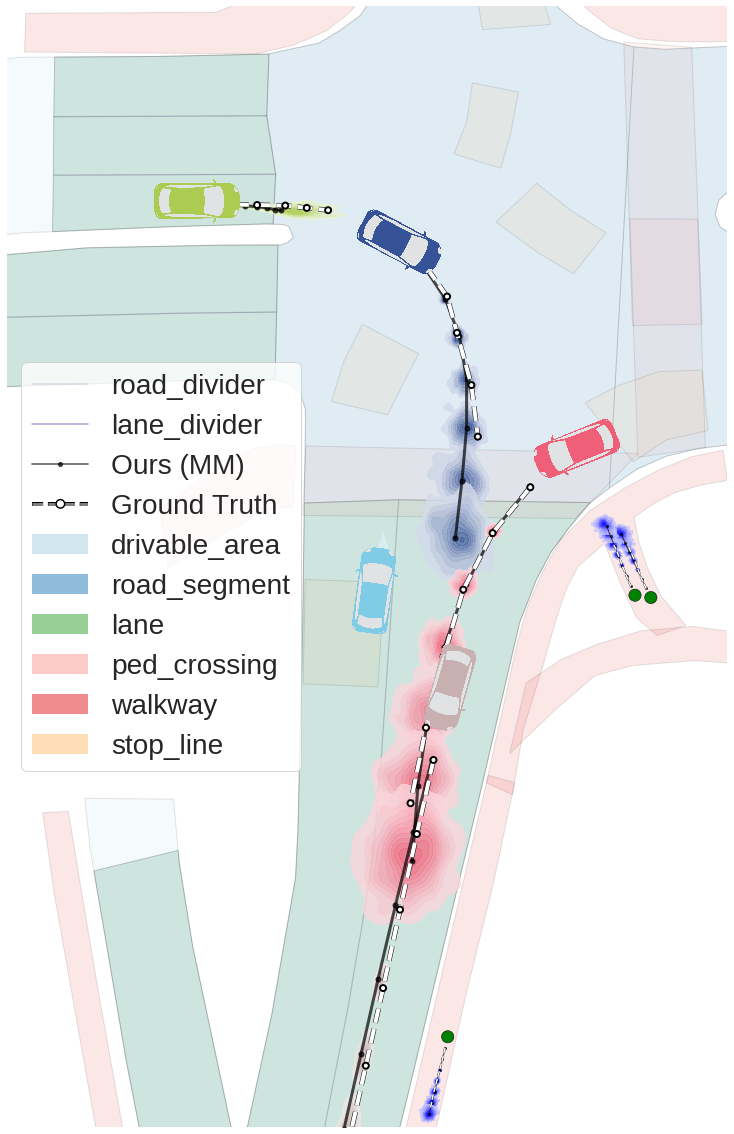

In [10]:
ph = 7
with torch.no_grad():
    timestep = np.array([32])
    predictions = eval_stg.predict(scene,
                                   timestep,
                                   ph,
                                   num_samples_z=500,
                                   most_likely_z=False,
                                   all_z=False,
                                   most_likely_gmm=False)

    predictions_mm = eval_stg.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples_z=1,
                                      most_likely_z=True,
                                      all_z=False,
                                      most_likely_gmm=True)

    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10, 22.4), alpha=0.1, render_egoposes_range=False)

    ax.plot([], [], 'ko-',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (MM)')

    ax.plot([],
            [],
            'w--o', label='Ground Truth',
            linewidth=3,
            path_effects=[pe.Stroke(linewidth=4, foreground='k'), pe.Normal()])

    plot_vehicle_nice(ax,
                      predictions,
                      scene.dt,
                      max_hl=10,
                      ph=ph,
                      map=None, x_min=x_min, y_min=y_min)

    plot_vehicle_mm(ax,
                    predictions_mm,
                    scene.dt,
                    max_hl=10,
                    ph=ph,
                    map=None, x_min=x_min, y_min=y_min)

    ax.set_ylim((1965, 2020))
    ax.set_xlim((370, 405))
    leg = ax.legend(loc='center left', fontsize=28, frameon=True)
    ax.axis('off')
    for lh in leg.legendHandles:
        lh.set_alpha(.5)
    fig.show()
    # fig.savefig('plots/qual_nuScenes_map.pdf', dpi=300, bbox_inches='tight')

## Prediction without Map Encoding

In [11]:
model_dir = os.path.join(log_dir, 'baseline') 
eval_stg_nm, hyp = load_model(model_dir, eval_env, ts=1)


Loading from ../../data/nuScenes/models/baseline/model_registrar-1.pt
Loaded!



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


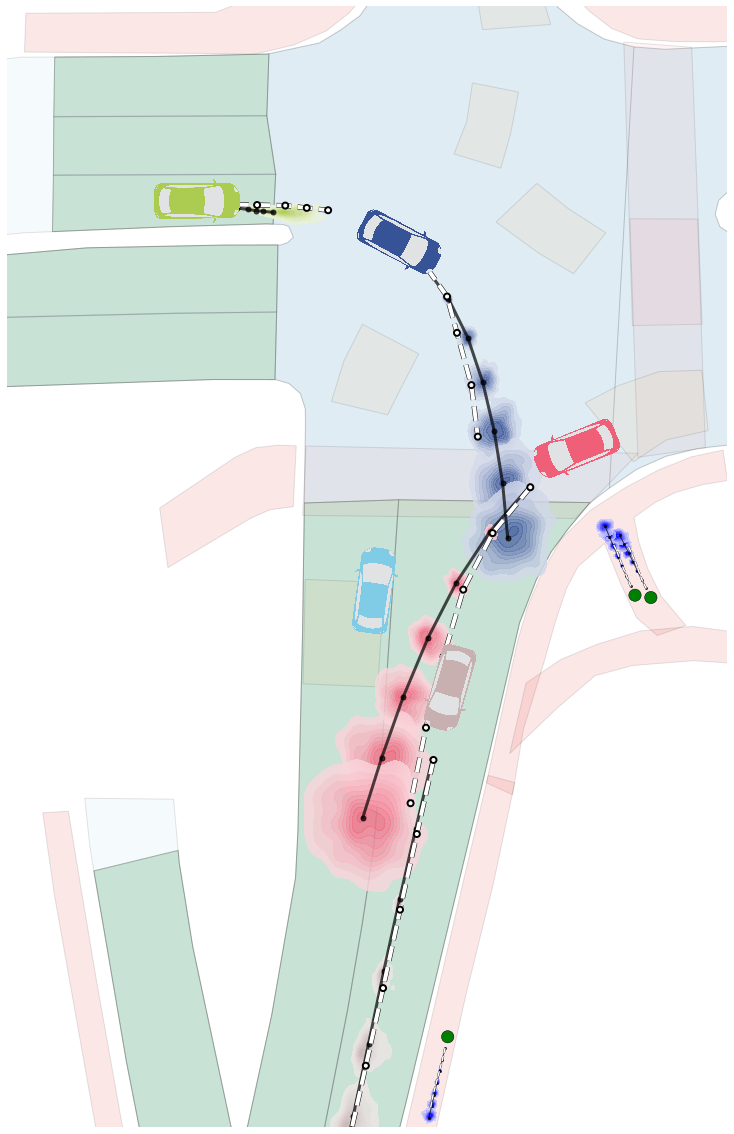

In [12]:
with torch.no_grad():
    timestep = np.array([32])
    predictions = eval_stg_nm.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples_z=500,
                                      most_likely_z=False,
                                      all_z=False,
                                      most_likely_gmm=False)

    predictions_mm = eval_stg_nm.predict(scene,
                                         timestep,
                                         ph,
                                         num_samples_z=1,
                                         most_likely_z=True,
                                         all_z=False,
                                         most_likely_gmm=True)

    # Plot predicted timestep for random scene in map
    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, nusc_map.non_geometric_layers[:-1], figsize=(10, 22.4), alpha=0.1,
                                        render_egoposes_range=False)

    ax.plot([], [], 'ko-',
            zorder=620,
            markersize=4,
            linewidth=2, alpha=0.7, label='Ours (MM)')

    ax.plot([],
            [],
            'w--',
            linewidth=4,
            zorder=650,
            path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()], label="Ground Truth")

    plot_vehicle_nice(ax,
                      predictions,
                      scene.dt,
                      max_hl=10,
                      ph=ph,
                      map=None, x_min=x_min, y_min=y_min)
    plot_vehicle_mm(ax,
                    predictions_mm,
                    scene.dt,
                    max_hl=10,
                    ph=ph,
                    map=None, x_min=x_min, y_min=y_min)

    ax.set_ylim((1965, 2020))
    ax.set_xlim((370, 405))
    ax.axis('off')
    ax.get_legend().remove()
    fig.show()
    # fig.savefig('plots/qual_nuScenes_no_map.pdf', dpi=300, bbox_inches='tight')

# Robot Future Influence Demo

In [13]:
with open('../../data/processed/nuScenes_samples.pkl', 'rb') as f:
    eval_env = pickle.load(f, encoding='latin1')
eval_scenes = eval_env.scenes

In [14]:
ph = 6
model_dir = os.path.join(log_dir, 'robot_demo') 
eval_stg_nm, hyp = load_model(model_dir, eval_env, ts=1)


Loading from ../../data/nuScenes/models/robot_demo/model_registrar-1.pt
Loaded!



In [15]:
# Define ROI in nuScenes map
x_min = 277
x_max = 523
y_min = 1515
y_max = 1783

In [16]:
nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name='boston-seaport')

In [17]:
for s_scene in eval_scenes:
    if s_scene.name == "234":
        scene = s_scene
        print('Found')

Found


In [18]:
keep_nodes = []
for i in range(len(scene.nodes)):
    if scene.nodes[i].position.x[0] > 140 and scene.nodes[i].position.x[0] < 160:
        if scene.nodes[i].position.y[0] > 104 and scene.nodes[i].position.y[0] < 120:
            keep_nodes.append(scene.nodes[i])
scene.nodes = keep_nodes

In [19]:
layers = ['drivable_area',
 'lane',
 'ped_crossing',
 'walkway',
 'road_divider',
 'lane_divider']

## Robot normal acceleration

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


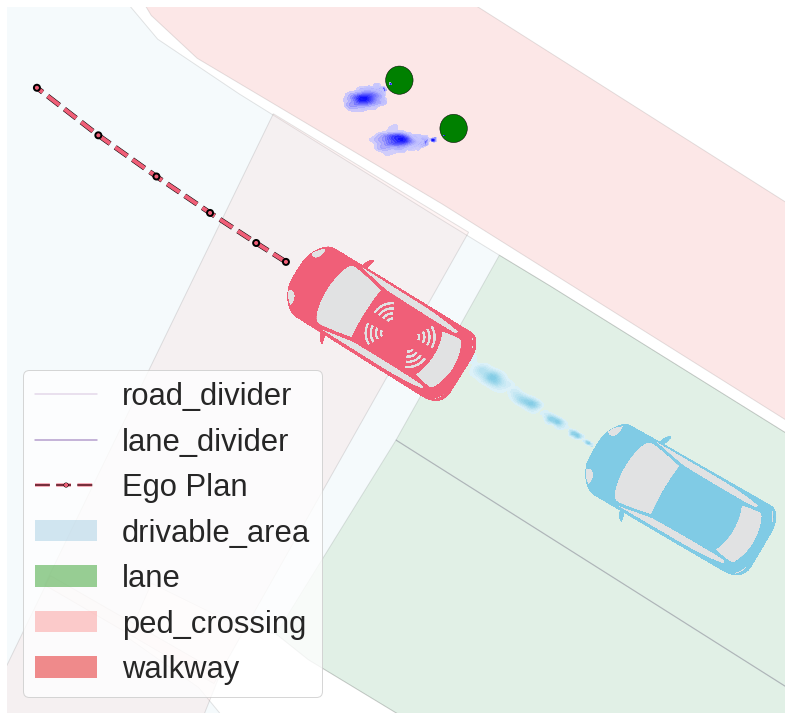

In [22]:
with torch.no_grad():
    timestep = np.array([9])
    predictions = eval_stg_nm.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples_z=100,
                                      most_likely_z=False,
                                      all_z=False,
                                      min_future_timesteps=ph,
                                      most_likely_gmm=False)

    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10.8, 9), alpha=0.1, render_egoposes_range=False,
                                        render_legend=False)
    hand, labl = ax.get_legend_handles_labels()
    handout = []
    lablout = []
    ax.legend(handout, lablout)
    fig.legend(handout, lablout)
    ax.plot([],
            [],
            '--o',
            c='#F05F78',
            linewidth=4,
            markersize=3,
            zorder=650,
            path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()], label="Ego Plan")

    plot_vehicle_nice_mv(ax,
                         predictions,
                         scene.dt,
                         max_hl=10,
                         ph=ph,
                         map=None, x_min=x_min, y_min=y_min)

    test = {'u': 2}
    p_robot = dict()
    p_robot[timestep[0]] = {scene.robot: np.zeros((1, 1, ph, 2))}

    plot_vehicle_nice_mv_robot(ax,
                               p_robot,
                               scene.dt,
                               max_hl=10,
                               ph=ph,
                               map=None, x_min=x_min, y_min=y_min)

    ax.set_ylim((1615, 1630))
    ax.set_xlim((418, 435))
    ax.axis('off')
    leg = ax.legend(loc='lower left', fontsize=31, frameon=True)
    ax.axis('off')
    for lh in leg.legendHandles:
        lh.set_alpha(.5)
    # leg.remove()
    fig.show()
    #fig.savefig('plots/qual_nuScenes_robot_vel.pdf', dpi=300, bbox_inches='tight')

# Robot decrease acceleration

In [23]:
breaking_at_t = 10
breaking_sequence = np.arange(1, scene.timesteps - breaking_at_t + 1)
scene.robot.velocity.x[breaking_at_t:] = 0.25 * scene.robot.velocity.x[breaking_at_t:]
scene.robot.velocity.y[breaking_at_t:] = 0.25 * scene.robot.velocity.y[breaking_at_t:]
scene.robot.position.x[breaking_at_t:] = np.squeeze(integrate(scene.robot.velocity.x[np.newaxis, breaking_at_t:], 0.5, scene.robot.position.x[breaking_at_t]))
scene.robot.position.y[breaking_at_t:] = np.squeeze(integrate(scene.robot.velocity.y[np.newaxis, breaking_at_t:], 0.5, scene.robot.position.y[breaking_at_t]))
scene.robot.acceleration.x = np.gradient(scene.robot.velocity.x[breaking_at_t:], 0.5)
scene.robot.acceleration.y = np.gradient(scene.robot.velocity.y[breaking_at_t:], 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


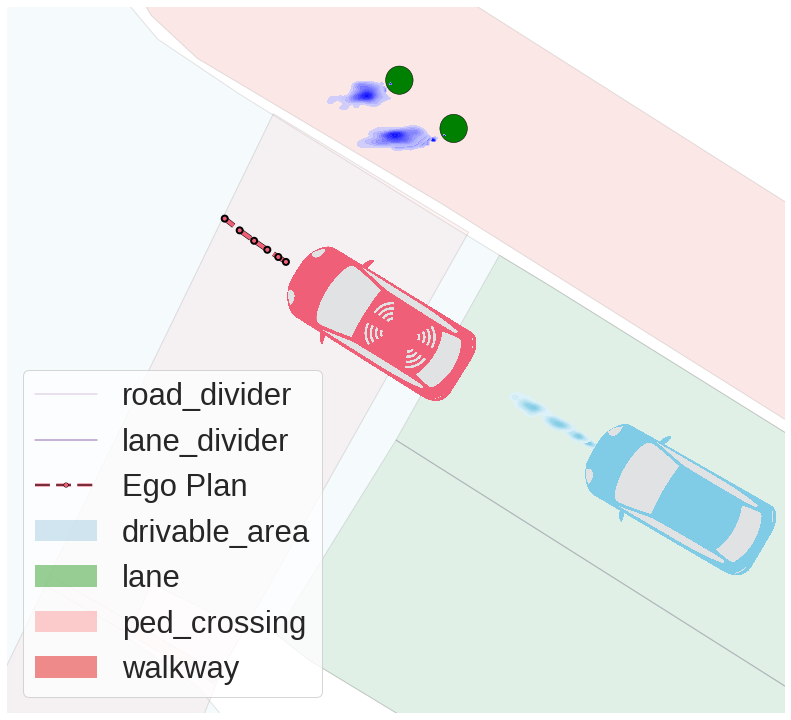

In [24]:
with torch.no_grad():
    timestep = np.array([9])
    predictions = eval_stg_nm.predict(scene,
                                      timestep,
                                      ph,
                                      num_samples_z=100,
                                      most_likely_z=False,
                                      all_z=False,
                                      min_future_timesteps=ph,
                                      most_likely_gmm=False)

    my_patch = (x_min, y_min, x_max, y_max)
    fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10.8, 9), alpha=0.1, render_egoposes_range=False,
                                        render_legend=False)
    hand, labl = ax.get_legend_handles_labels()
    handout = []
    lablout = []
    ax.legend(handout, lablout)
    fig.legend(handout, lablout)
    ax.plot([],
            [],
            '--o',
            c='#F05F78',
            linewidth=4,
            markersize=3,
            zorder=650,
            path_effects=[pe.Stroke(linewidth=2, foreground='k'), pe.Normal()], label="Ego Plan")

    plot_vehicle_nice_mv(ax,
                         predictions,
                         scene.dt,
                         max_hl=10,
                         ph=ph,
                         map=None, x_min=x_min, y_min=y_min)

    test = {'u': 2}
    p_robot = dict()
    p_robot[timestep[0]] = {scene.robot: np.zeros((1, 1, ph, 2))}

    plot_vehicle_nice_mv_robot(ax,
                               p_robot,
                               scene.dt,
                               max_hl=10,
                               ph=ph,
                               map=None, x_min=x_min, y_min=y_min)

    ax.set_ylim((1615, 1630))
    ax.set_xlim((418, 435))
    ax.axis('off')
    leg = ax.legend(loc='lower left', fontsize=31, frameon=True)
    ax.axis('off')
    for lh in leg.legendHandles:
        lh.set_alpha(.5)
    # leg.remove()
    fig.show()
    #fig.savefig('plots/qual_nuScenes_robot_no_vel.pdf', dpi=300, bbox_inches='tight')